In [1]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from scipy.optimize import minimize

This notebook assesses the error in RACs-based ML models, as trained with the `train.py` script in the RACs subfolder.

In [2]:
#to get the energy errors
csd_sse_df = pd.read_csv('../data/cleaned_csd76_sse.csv').set_index('Unnamed: 0')
csd_hfx_df = pd.read_csv('../data/CSD76targets.csv').set_index('Unnamed: 0')
csd_76 = pd.read_csv('../data/CSD-76.csv').set_index('name')

vss_sse_df = pd.read_csv('../data/cleaned_vss452_sse.csv').set_index('Unnamed: 0')
#rename so that the convention matches the original VSS-452
names = {}
for name in vss_sse_df.index:
    elems = name.split('/')
    names[name] =elems[-1]
vss_sse_df = vss_sse_df.rename(index=names)

vss_hfx_df = pd.read_csv('../data/VSS452targets.csv').set_index('Unnamed: 0')
names = {}
for name in vss_hfx_df.index:
    elems = name.split('/')
    names[name] =elems[-1]
vss_hfx_df = vss_hfx_df.rename(index=names)

vss_452 = pd.read_csv('../data/VSS-452.csv').set_index('name')

def pred_energy(structure, dataset, functional, pred_hfx):
    #structure is the name of the complex, dataset is whether the structure is from vss or csd, 
    #functional is the functional used
    if dataset == 'csd':
        df = csd_76
        sse_df = csd_sse_df
        hfx_df = csd_hfx_df
    elif dataset == 'vss':
        df = vss_452
        sse_df = vss_sse_df
        hfx_df = vss_hfx_df
    else:
        raise ValueError("Specify a valid dataset!")
    if np.isnan(pred_hfx):
        return
    
    sses = []
    all_increments = np.arange(0, 101, 5)
    increments = []
    for increment in all_increments:
        sse = sse_df.loc[structure][functional + '_hfx_' + str(increment)]
        if not np.isnan(sse):
            increments.append(increment)
            sses.append(sse)
    if len(increments) < 5:
        #print('Not enough converged values!')
        return

    line = interp1d(increments, sses, kind='linear', fill_value='extrapolate')
    return line(pred_hfx)

def get_energy_error(pred_df, pred_name, functional, dataset):
    errors = []
    if dataset == 'csd':
        df = csd_76
    else:
        df = vss_452
    for idx, row in pred_df.iterrows():
        pred = pred_energy(idx, dataset, functional, row[pred_name])
        errors.append(pred - df.loc[idx]['dlpno-CCSD_T.vertsse'])
    return np.mean(np.abs(np.array(errors)))

# Obtaining Errors

In [3]:
def get_errors(pred_df, csd_pred_df, functional, model, seed):
    name = functional + '-' + model +'-' + str(seed)
    set_name = functional + '-' + model +'-set-' + str(seed)
    train = pred_df[pred_df[set_name] == 'train']
    val = pred_df[pred_df[set_name] == 'val']
    test = pred_df[pred_df[set_name] == 'test']

    if functional == 'pbe':
        ref = 'hfx_pbe'
    elif functional == 'scan':
        ref = 'hfx_scan'
    else:
        raise ValueError('Provide a functional pbe or scan')
    csd = csd_pred_df[[not np.isnan(x) for x in csd_pred_df[name]]] #remove all structures not in the csd set

    train_hfx_mae = np.mean(np.abs(train[ref] - train[name].clip(0, 100)))
    val_hfx_mae = np.mean(np.abs(val[ref] - val[name]))
    test_hfx_mae = np.mean(np.abs(test[ref] - test[name]))
    csd_hfx_mae = np.mean(np.abs(csd[ref] - csd[name]))

    train_energy_mae = get_energy_error(train, name, functional, 'vss')
    val_energy_mae = get_energy_error(val, name, functional, 'vss')
    test_energy_mae = get_energy_error(test, name, functional, 'vss')
    csd_energy_mae = get_energy_error(csd, name, functional, 'csd')

    return train_hfx_mae, val_hfx_mae, test_hfx_mae, csd_hfx_mae, train_energy_mae, val_energy_mae, test_energy_mae, csd_energy_mae

def make_parity(pred_df, csd_pred_df, model, seed):
    fig, ax = plt.subplots(ncols=4, nrows=2, figsize=(16, 8))
    for idx, functional in enumerate(['pbe', 'scan']):
        name = functional + '-' + model +'-' + str(seed)
        set_name = functional + '-' + model +'-set-' + str(seed)
        train = pred_df[pred_df[set_name] == 'train']
        val = pred_df[pred_df[set_name] == 'val']
        test = pred_df[pred_df[set_name] == 'test']

        if functional == 'pbe':
            ref = 'hfx_pbe'
        elif functional == 'scan':
            ref = 'hfx_scan'
        csd = csd_pred_df[[not np.isnan(x) for x in csd_pred_df[name]]] #remove all structures not in the csd set
    
        train_hfx_mae, val_hfx_mae, test_hfx_mae, csd_hfx_mae, train_energy_mae, val_energy_mae, test_energy_mae, csd_energy_mae = \
        get_errors(pred_df, csd_pred_df, functional, model, seed)
        ax[idx, 0].scatter(train[ref], train[name], color='#00C440', alpha=0.5)
        ax[idx, 0].set_title(f'{functional.upper()} Train')
        ax[idx, 1].scatter(val[ref], val[name], color='#FF0000', alpha=0.5)
        ax[idx, 1].set_title(f'{functional.upper()} Val')
        ax[idx, 2].scatter(test[ref], test[name], color='#0000FF', alpha=0.5)
        ax[idx, 2].set_title(f'{functional.upper()} Test')
        ax[idx, 3].scatter(csd[ref], csd[name], color='#8c8c8c', alpha=0.5)
        ax[idx, 3].set_title(f'{functional.upper()} CSD')
    
        for i in range(4):
            ax[idx, i].set_xlim(-5, 105)
            ax[idx, i].set_ylim(-5, 105)
            ax[idx, i].plot((0, 100), (0, 100), 'k--')
            ax[idx, i].set_xlabel('Optimal HFX%')
            ax[idx, i].set_ylabel('Predicted HFX%')
        
        ax[idx, 0].text(0, 85, f'MAE = {train_hfx_mae:1.2f} HFX% \nMAE = {train_energy_mae:1.2f} kcal/mol', bbox=dict(edgecolor='black', facecolor='white'))
        ax[idx, 1].text(0, 85, f'MAE = {val_hfx_mae:1.2f} HFX% \nMAE = {val_energy_mae:1.2f} kcal/mol', bbox=dict(edgecolor='black', facecolor='white'))
        ax[idx, 2].text(0, 85, f'MAE = {test_hfx_mae:1.2f} HFX% \nMAE = {test_energy_mae:1.2f} kcal/mol', bbox=dict(edgecolor='black', facecolor='white'))
        ax[idx, 3].text(0, 85, f'MAE = {csd_hfx_mae:1.2f} HFX% \nMAE = {csd_energy_mae:1.2f} kcal/mol', bbox=dict(edgecolor='black', facecolor='white'))
    
        fig.suptitle(f'{model.upper()}, Random Seed {seed}')
        fig.tight_layout()

In [4]:
vss_preds = pd.read_csv('RACs/vss_racs_predictions.csv').set_index('Unnamed: 0')
csd_preds = pd.read_csv('RACs/csd_racs_predictions.csv').set_index('Unnamed: 0')

#restrict targets and predictions between 0 and 100
cols = vss_preds.select_dtypes(include=np.number).columns
vss_preds[cols] = vss_preds[cols].clip(0, 100)

cols = csd_preds.select_dtypes(include=np.number).columns
csd_preds[cols] = csd_preds[cols].clip(0, 100)

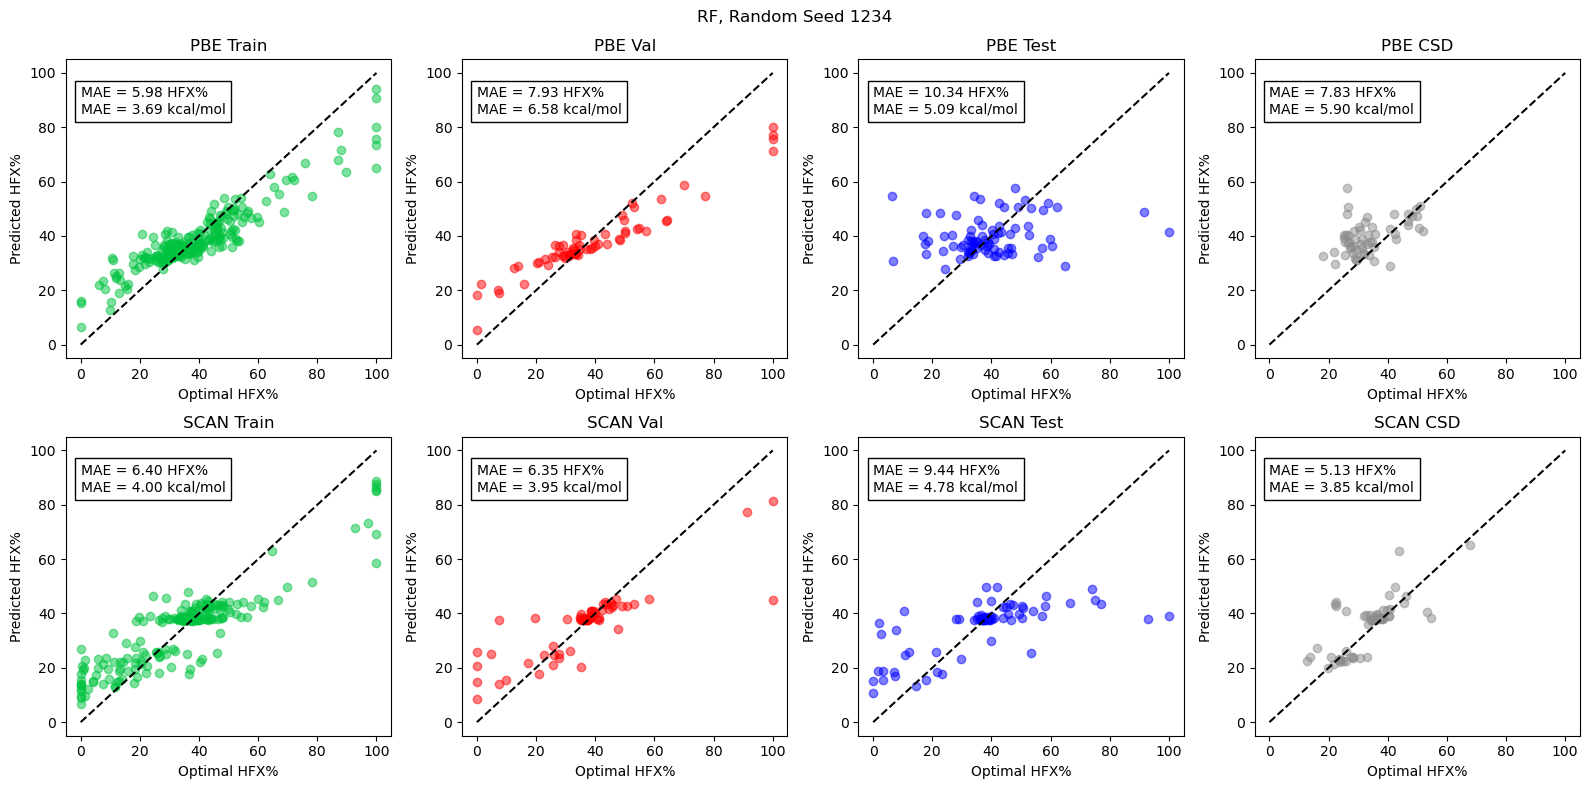

In [5]:
make_parity(vss_preds, csd_preds, 'rf', 1234)

In [6]:
seeds = [1234, 1337, 9876, 18558, 66464, 91625]

# RF Performance

In [7]:
rf_hfx_df = pd.DataFrame(columns=['pbe_train', 'pbe_val', 'pbe_test', 'pbe_csd', 'scan_train', 'scan_val', 'scan_test', 'scan_csd'], index=seeds)
rf_energy_df = pd.DataFrame(columns=['pbe_train', 'pbe_val', 'pbe_test', 'pbe_csd', 'scan_train', 'scan_val', 'scan_test', 'scan_csd'], index=seeds)

for seed in tqdm(seeds):
    train_hfx_mae, val_hfx_mae, test_hfx_mae, csd_hfx_mae, \
    train_energy_mae, val_energy_mae, test_energy_mae, csd_energy_mae = \
    get_errors(vss_preds, csd_preds, 'pbe', 'rf', seed)
    rf_hfx_df['pbe_train'][seed] = train_hfx_mae
    rf_hfx_df['pbe_val'][seed] = val_hfx_mae
    rf_hfx_df['pbe_test'][seed] = test_hfx_mae
    rf_hfx_df['pbe_csd'][seed] = csd_hfx_mae
    rf_energy_df['pbe_train'][seed] = train_energy_mae
    rf_energy_df['pbe_val'][seed] = val_energy_mae
    rf_energy_df['pbe_test'][seed] = test_energy_mae
    rf_energy_df['pbe_csd'][seed] = csd_energy_mae

    train_hfx_mae, val_hfx_mae, test_hfx_mae, csd_hfx_mae, \
    train_energy_mae, val_energy_mae, test_energy_mae, csd_energy_mae = \
    get_errors(vss_preds, csd_preds, 'scan', 'rf', seed)
    rf_hfx_df['scan_train'][seed] = train_hfx_mae
    rf_hfx_df['scan_val'][seed] = val_hfx_mae
    rf_hfx_df['scan_test'][seed] = test_hfx_mae
    rf_hfx_df['scan_csd'][seed] = csd_hfx_mae
    rf_energy_df['scan_train'][seed] = train_energy_mae
    rf_energy_df['scan_val'][seed] = val_energy_mae
    rf_energy_df['scan_test'][seed] = test_energy_mae
    rf_energy_df['scan_csd'][seed] = csd_energy_mae

100%|█████████████████████████████████████████████| 6/6 [00:15<00:00,  2.66s/it]


In [8]:
pd.concat([rf_hfx_df, rf_hfx_df.apply(['mean', 'std'])])

,pbe_train,pbe_val,pbe_test,pbe_csd,scan_train,scan_val,scan_test,scan_csd
1234,5.977842,7.929975,10.33857,7.832926,6.403334,6.350431,9.440962,5.130888
1337,9.181272,9.328334,10.124146,8.955432,6.730001,5.321783,9.356191,7.768554
9876,5.682039,5.915819,13.020961,7.967078,4.019011,4.335062,9.077669,7.355026
18558,3.929315,3.395071,12.01519,7.493198,3.825498,4.963458,11.59216,8.011346
66464,8.505207,10.052513,12.370494,7.701002,4.087144,6.192092,8.661508,7.97364
91625,4.430049,4.68901,11.37742,8.663043,6.00059,6.21478,12.634049,5.837414
mean,6.284287,6.88512,11.54113,8.102113,5.177596,5.562934,10.12709,7.012811
std,2.133809,2.647122,1.147455,0.577089,1.337856,0.820498,1.596593,1.227331


In [9]:
pd.concat([rf_energy_df, rf_energy_df.apply(['mean', 'std'])])

,pbe_train,pbe_val,pbe_test,pbe_csd,scan_train,scan_val,scan_test,scan_csd
1234,3.689235,6.578309,5.092133,5.898533,4.000937,3.952885,4.777782,3.851496
1337,5.499247,6.302952,5.768995,6.600757,3.584957,3.536267,4.420638,5.846156
9876,3.439688,3.244009,7.94099,5.755356,2.562529,2.701428,5.044328,5.493015
18558,2.31838,2.384168,7.784127,5.633804,2.646463,2.621691,5.38079,6.031127
66464,5.331617,5.005088,5.915001,5.798363,2.601752,2.829701,4.329438,5.978709
91625,3.040715,3.110097,5.637293,6.507071,3.433332,3.131855,6.596695,4.371619
mean,3.88648,4.437437,6.356423,6.032314,3.138328,3.128971,5.091612,5.26202
std,1.272967,1.776948,1.200391,0.413925,0.61514,0.524294,0.834355,0.925433


# XGBoost Performance

In [10]:
xgb_hfx_df = pd.DataFrame(columns=['pbe_train', 'pbe_val', 'pbe_test', 'pbe_csd', 'scan_train', 'scan_val', 'scan_test', 'scan_csd'], index=seeds)
xgb_energy_df = pd.DataFrame(columns=['pbe_train', 'pbe_val', 'pbe_test', 'pbe_csd', 'scan_train', 'scan_val', 'scan_test', 'scan_csd'], index=seeds)

for seed in tqdm(seeds):
    train_hfx_mae, val_hfx_mae, test_hfx_mae, csd_hfx_mae, \
    train_energy_mae, val_energy_mae, test_energy_mae, csd_energy_mae = \
    get_errors(vss_preds, csd_preds, 'pbe', 'xgb', seed)
    xgb_hfx_df['pbe_train'][seed] = train_hfx_mae
    xgb_hfx_df['pbe_val'][seed] = val_hfx_mae
    xgb_hfx_df['pbe_test'][seed] = test_hfx_mae
    xgb_hfx_df['pbe_csd'][seed] = csd_hfx_mae
    xgb_energy_df['pbe_train'][seed] = train_energy_mae
    xgb_energy_df['pbe_val'][seed] = val_energy_mae
    xgb_energy_df['pbe_test'][seed] = test_energy_mae
    xgb_energy_df['pbe_csd'][seed] = csd_energy_mae

    train_hfx_mae, val_hfx_mae, test_hfx_mae, csd_hfx_mae, \
    train_energy_mae, val_energy_mae, test_energy_mae, csd_energy_mae = \
    get_errors(vss_preds, csd_preds, 'scan', 'xgb', seed)
    xgb_hfx_df['scan_train'][seed] = train_hfx_mae
    xgb_hfx_df['scan_val'][seed] = val_hfx_mae
    xgb_hfx_df['scan_test'][seed] = test_hfx_mae
    xgb_hfx_df['scan_csd'][seed] = csd_hfx_mae
    xgb_energy_df['scan_train'][seed] = train_energy_mae
    xgb_energy_df['scan_val'][seed] = val_energy_mae
    xgb_energy_df['scan_test'][seed] = test_energy_mae
    xgb_energy_df['scan_csd'][seed] = csd_energy_mae

100%|█████████████████████████████████████████████| 6/6 [00:16<00:00,  2.67s/it]


In [11]:
pd.concat([xgb_hfx_df, xgb_hfx_df.apply(['mean', 'std'])])

,pbe_train,pbe_val,pbe_test,pbe_csd,scan_train,scan_val,scan_test,scan_csd
1234,0.549735,0.599419,12.596821,6.919286,0.000405,0.000424,10.304639,8.068643
1337,2.367551,2.201114,10.315099,8.91369,7.455019,6.327475,9.798079,5.892681
9876,2.213251,2.387436,11.875113,8.673564,4.342452,4.914347,11.195623,6.18922
18558,0.147363,0.133623,13.490813,7.874228,0.821201,0.865464,12.987387,9.591103
66464,6.541642,6.703723,10.825186,7.694033,1.345948,1.50974,9.026305,9.274136
91625,3.922435,4.223042,10.266404,7.134578,9.095441,8.726524,13.406734,5.335617
mean,2.623663,2.70806,11.561573,7.86823,3.843411,3.723996,11.119794,7.3919
std,2.353918,2.436981,1.316468,0.801333,3.768722,3.468701,1.761695,1.830829


In [12]:
pd.concat([xgb_energy_df, xgb_energy_df.apply(['mean', 'std'])])

,pbe_train,pbe_val,pbe_test,pbe_csd,scan_train,scan_val,scan_test,scan_csd
1234,0.850009,2.089228,6.0511,5.387502,0.77502,0.847334,5.498397,6.296143
1337,1.867154,2.867065,6.040469,6.624405,4.17736,4.668866,4.506619,4.426942
9876,1.859219,1.596194,7.487881,6.674564,2.859736,2.966193,6.454807,4.677631
18558,0.38697,0.722379,8.54536,6.133067,1.256136,0.819294,6.15588,6.866393
66464,4.412551,3.410971,5.1964,5.628934,1.326045,1.49563,4.624746,6.755708
91625,2.829639,2.981154,5.003583,5.476485,4.9294,4.793332,6.738524,3.937949
mean,2.034257,2.277832,6.387465,5.987493,2.55395,2.598441,5.663162,5.493461
std,1.446615,1.00454,1.373662,0.574212,1.716298,1.826876,0.945402,1.291911


# MLP Performance

In [13]:
mlp_hfx_df = pd.DataFrame(columns=['pbe_train', 'pbe_val', 'pbe_test', 'pbe_csd', 'scan_train', 'scan_val', 'scan_test', 'scan_csd'], index=seeds)
mlp_energy_df = pd.DataFrame(columns=['pbe_train', 'pbe_val', 'pbe_test', 'pbe_csd', 'scan_train', 'scan_val', 'scan_test', 'scan_csd'], index=seeds)

for seed in tqdm(seeds):
    train_hfx_mae, val_hfx_mae, test_hfx_mae, csd_hfx_mae, \
    train_energy_mae, val_energy_mae, test_energy_mae, csd_energy_mae = \
    get_errors(vss_preds, csd_preds, 'pbe', 'mlp', seed)
    mlp_hfx_df['pbe_train'][seed] = train_hfx_mae
    mlp_hfx_df['pbe_val'][seed] = val_hfx_mae
    mlp_hfx_df['pbe_test'][seed] = test_hfx_mae
    mlp_hfx_df['pbe_csd'][seed] = csd_hfx_mae
    mlp_energy_df['pbe_train'][seed] = train_energy_mae
    mlp_energy_df['pbe_val'][seed] = val_energy_mae
    mlp_energy_df['pbe_test'][seed] = test_energy_mae
    mlp_energy_df['pbe_csd'][seed] = csd_energy_mae

    train_hfx_mae, val_hfx_mae, test_hfx_mae, csd_hfx_mae, \
    train_energy_mae, val_energy_mae, test_energy_mae, csd_energy_mae = \
    get_errors(vss_preds, csd_preds, 'scan', 'mlp', seed)
    mlp_hfx_df['scan_train'][seed] = train_hfx_mae
    mlp_hfx_df['scan_val'][seed] = val_hfx_mae
    mlp_hfx_df['scan_test'][seed] = test_hfx_mae
    mlp_hfx_df['scan_csd'][seed] = csd_hfx_mae
    mlp_energy_df['scan_train'][seed] = train_energy_mae
    mlp_energy_df['scan_val'][seed] = val_energy_mae
    mlp_energy_df['scan_test'][seed] = test_energy_mae
    mlp_energy_df['scan_csd'][seed] = csd_energy_mae

100%|█████████████████████████████████████████████| 6/6 [00:15<00:00,  2.67s/it]


In [14]:
pd.concat([mlp_hfx_df, mlp_hfx_df.apply(['mean', 'std'])])

,pbe_train,pbe_val,pbe_test,pbe_csd,scan_train,scan_val,scan_test,scan_csd
1234,13.196907,16.352998,13.047938,32.580469,13.584753,12.196269,16.174825,26.10111
1337,13.383162,14.675418,12.566257,27.413029,13.549506,12.076565,12.99524,24.978991
9876,11.539607,11.322802,13.911396,25.794012,17.060039,18.684445,21.08365,22.348843
18558,14.161775,11.679527,14.322652,27.134229,14.824894,15.960082,16.866162,27.514653
66464,21.211812,22.245892,20.134272,14.531152,14.325775,16.380335,14.550026,28.221432
91625,12.102559,12.386684,13.804135,29.356885,12.278772,10.76942,17.444962,23.999334
mean,14.26597,14.77722,14.631108,26.134963,14.270623,14.344519,16.519144,25.527394
std,3.529624,4.135647,2.769544,6.153405,1.615488,3.102563,2.765001,2.20341


In [15]:
pd.concat([mlp_energy_df, mlp_energy_df.apply(['mean', 'std'])])

,pbe_train,pbe_val,pbe_test,pbe_csd,scan_train,scan_val,scan_test,scan_csd
1234,7.200909,11.498865,6.36856,22.587662,7.5567,7.440657,8.695083,19.212317
1337,7.338581,9.026873,7.275039,19.365378,7.481632,7.608593,6.498969,18.314779
9876,6.517925,6.241851,8.018755,18.189904,10.20463,9.705641,12.953,16.454902
18558,7.615285,6.922734,9.341533,19.141992,8.92626,8.160787,8.609408,20.077313
66464,13.569096,12.618534,10.840746,11.614807,8.510614,7.949727,7.746186,20.685275
91625,7.116238,6.94587,6.669835,20.615096,6.862316,6.102864,9.343581,17.451845
mean,8.226339,8.875788,8.085745,18.585807,8.257025,7.828045,8.974371,18.699405
std,2.642312,2.660381,1.719436,3.736349,1.211796,1.168364,2.182341,1.602967
